In [1]:
!pip install diffusers

In [52]:
import torch
from torchvision import transforms
from transformers import SamModel, SamProcessor
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid
import matplotlib.pyplot as plt

## Load input image

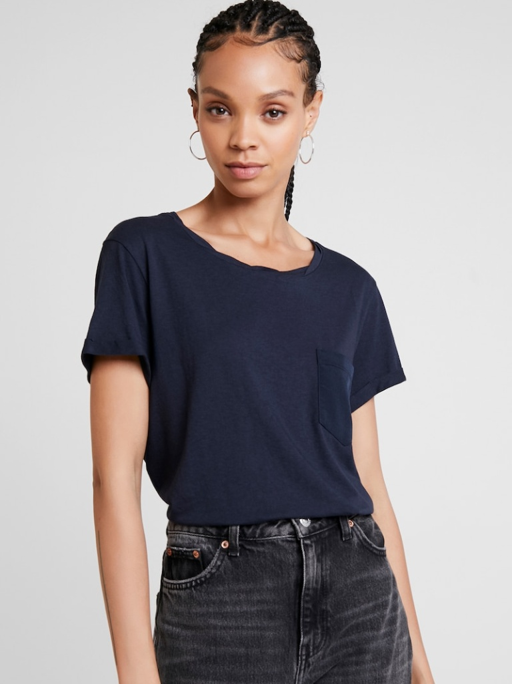

In [53]:

img = load_image("/content/00003_00.jpg")

img = img.resize([512,684])
img

## Import SlimSAM for creating masks

In [54]:
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-50").to("cuda")
processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-50")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

## Create mask for T-shirt

In [55]:
input_points = [[[250, 300]]]

inputs = processor(img, input_points=input_points, return_tensors="pt").to("cuda")
outputs = model(**inputs)


masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

In [15]:

len(masks[0][0])

3

Now you can plot all these masks one-by-one and see which one is the best for the object that you want to select.

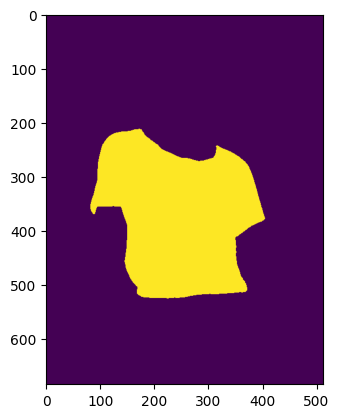

In [16]:
# best mask tensor
plt.imshow(masks[0][0][2])

I am now trying to implement pose

In [28]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

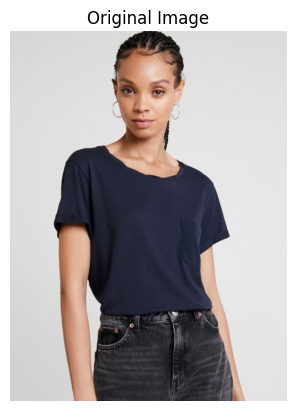

In [31]:


img = load_image("/content/00003_00.jpg")

img = img.resize([512,684])
img

# Display the original image to check
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [37]:

pil_image = Image.open("/content/00003_00.jpg").convert("RGB")

# 3. Convert the PIL Image to a NumPy array (this is the crucial step)
image_as_numpy_array = np.array(pil_image)
# Initialize MediaPipe Pose solution
# Initialize the MediaPipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Now, process the correctly formatted NumPy array
results = pose.process(image_as_numpy_array)

# Check if any pose was detected
if not results.pose_landmarks:
    print("Could not detect any pose in the image.")
else:
    print("Pose detected successfully!")


Pose detected successfully!


In [38]:


# Create a copy of the image to draw on
annotated_image = image_as_numpy_array.copy()

# Initialize MediaPipe Drawing utility
mp_drawing = mp.solutions.drawing_utils

# Draw the pose landmarks and connections on the image
mp_drawing.draw_landmarks(
    annotated_image,
    results.pose_landmarks,
    mp_pose.POSE_CONNECTIONS,
    landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2),
    connection_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=2)
)

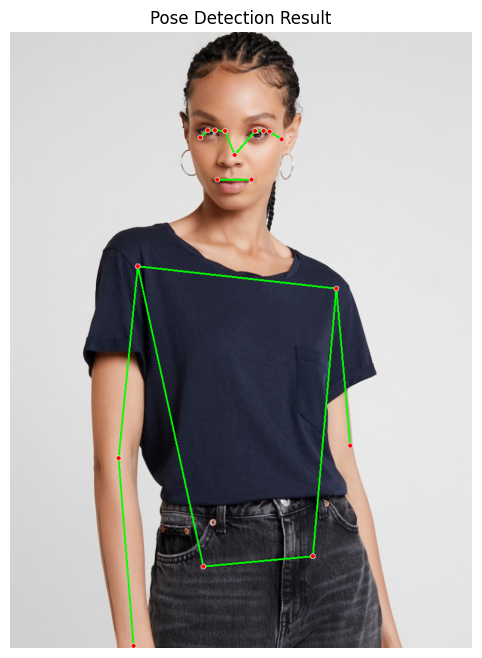

In [39]:
# Display the image with the pose landmarks
plt.figure(figsize=(8, 8))
plt.imshow(annotated_image)
plt.title("Pose Detection Result")
plt.axis('off')
plt.show()

In [40]:
pos_img = load_image("/content/pose_landmarks_index.png")

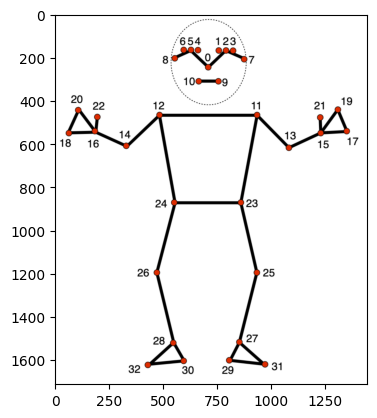

In [43]:
plt.imshow(pos_img)

In [44]:
def get_line_intersection(p1, p2, p3, p4):
    """
    Calculates the intersection point of two lines defined by two points each.
    Returns the intersection coordinates (x, y) or None if lines are parallel.
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4

    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denominator == 0:
        return None  # Lines are parallel

    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denominator
    intersection_x = int(x1 + t * (x2 - x1))
    intersection_y = int(y1 + t * (y2 - y1))

    return (intersection_x, intersection_y)

Intersection: (405, 710)


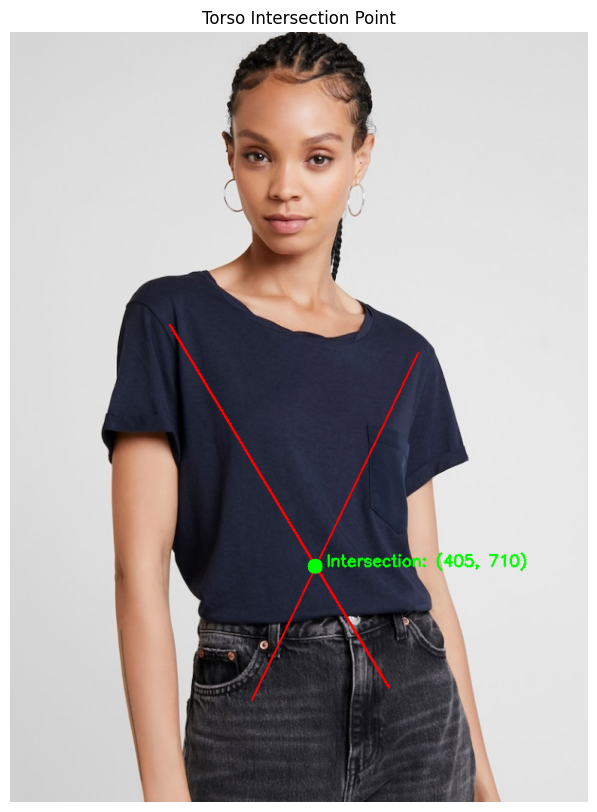

In [47]:
image_path = "/content/00003_00.jpg"
pil_image = Image.open(image_path).convert("RGB")
image = np.array(pil_image)
h, w, _ = image.shape


mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
results = pose.process(image)


annotated_image = image.copy()
if results.pose_landmarks:
    landmarks = results.pose_landmarks.landmark


    p11 = (int(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x * w), int(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y * h))
    p12 = (int(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x * w), int(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y * h))
    p23 = (int(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x * w), int(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y * h))
    p24 = (int(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x * w), int(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y * h))

    intersection_point = get_line_intersection(p11, p24, p12, p23)

    if intersection_point:

        cv2.line(annotated_image, p11, p24, (255, 0, 0), 2)
        cv2.line(annotated_image, p12, p23, (255, 0, 0), 2)


        cv2.circle(annotated_image, intersection_point, 10, (0, 255, 0), -1)

        coord_text = f"Intersection: {intersection_point}"
        print(coord_text)

        cv2.putText(annotated_image, coord_text, (intersection_point[0] + 15, intersection_point[1]),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    else:
        print("Lines are parallel, no intersection found.")

else:
    print("Could not detect any pose in the image.")


plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.title("Torso Intersection Point")
plt.axis('off')
plt.show()


In [48]:
intersection_point

(405, 710)

## Create mask for pants

In [59]:
input_points_2 = [[[405, 710]]] # coordinates of a point on the object of interest

inputs_2 = processor(img, input_points=input_points_2, return_tensors="pt").to("cuda")
outputs_2 = model(**inputs_2)
masks_2 = processor.image_processor.post_process_masks(outputs_2.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 92.12 MiB is free. Process 5904 has 14.65 GiB memory in use. Of the allocated memory 13.82 GiB is allocated by PyTorch, and 725.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [57]:
# count number of masks
len(masks_2[0][0])

3

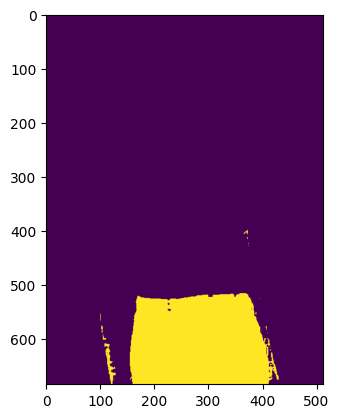

In [58]:
plt.imshow(masks_2[0][0][1])

## Convert PyTorch tensors to PIL image format

In [ ]:
# Create a ToPILImage transform
to_pil = transforms.ToPILImage()

# Convert boolean tensors to binary tensors
binary_matrix_1 = masks[0][0][2].to(dtype=torch.uint8)
binary_matrix_2 = masks_2[0][0][1].to(dtype=torch.uint8)

# apply the transform to the tensors (tensor to PIL)
mask_1 = to_pil(binary_matrix_1*255)
mask_2 = to_pil(binary_matrix_2*255)

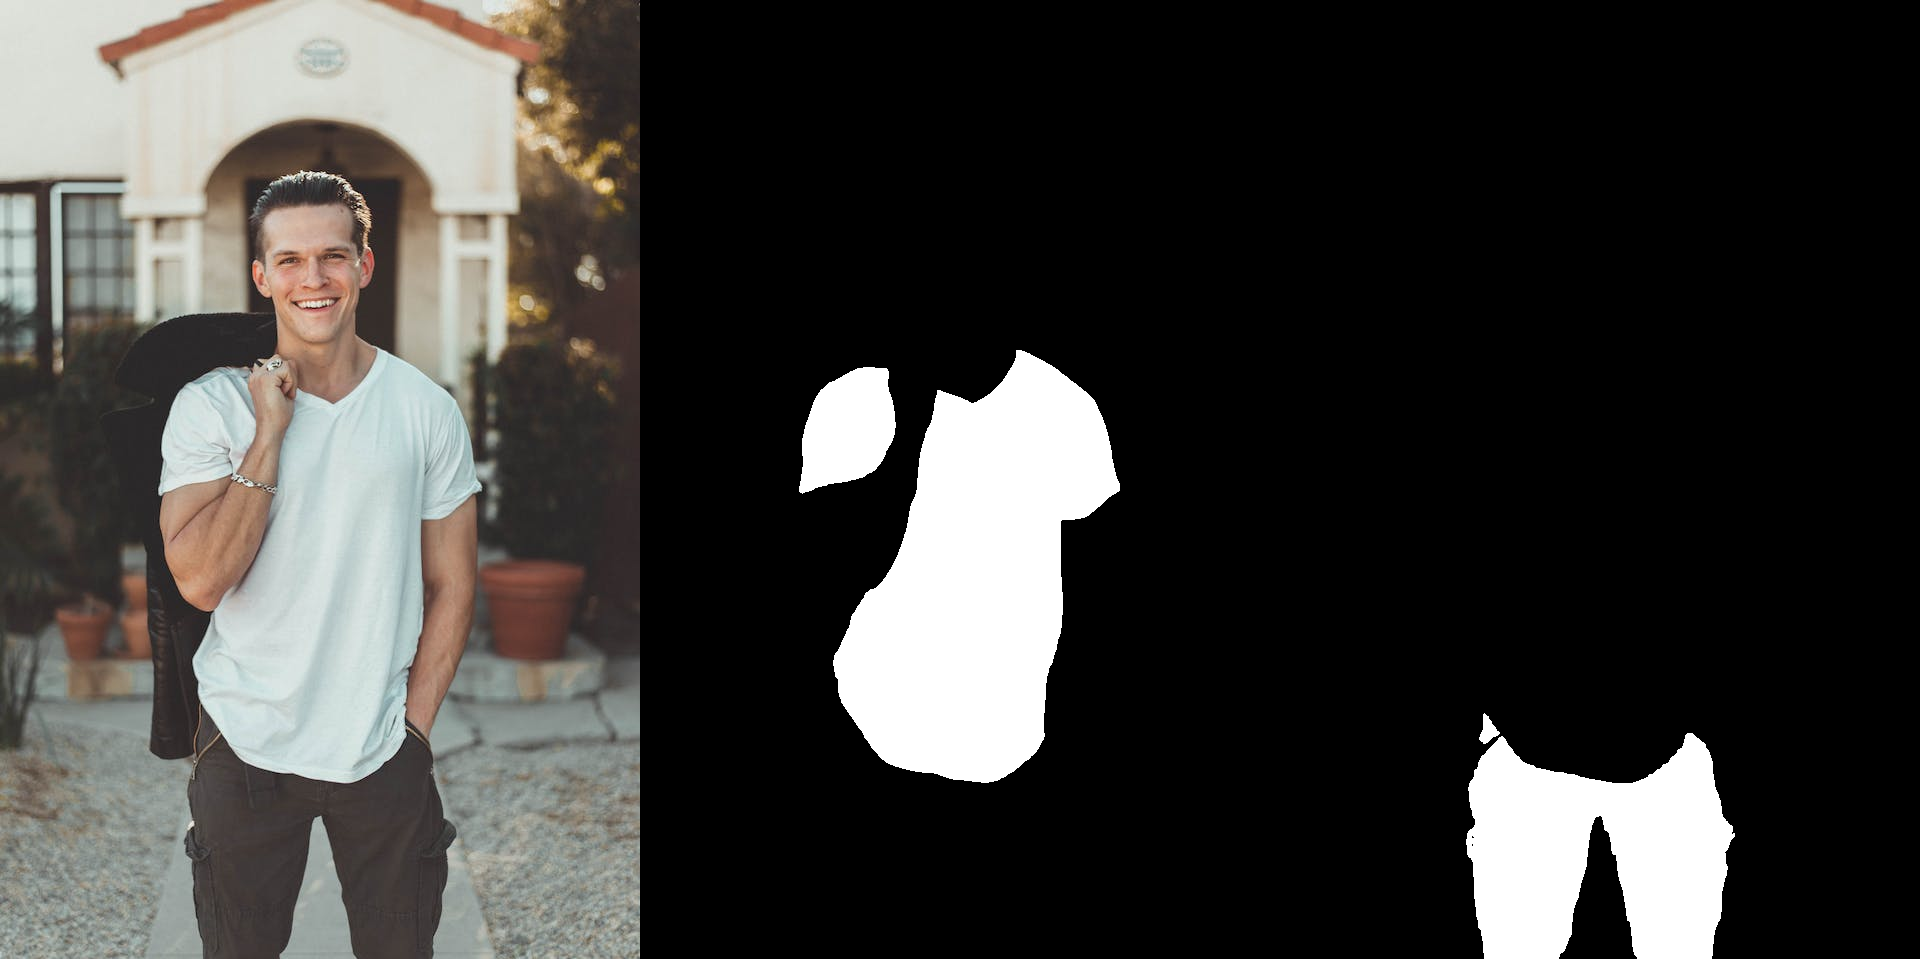

In [ ]:
# display original image with masks
make_image_grid([img, mask_1, mask_2], cols = 3, rows = 1)

## Import Stable Diffusion inpainting model

In [ ]:
# Create inpainting pipeline
pipeline = AutoPipelineForInpainting.from_pretrained(
    "redstonehero/ReV_Animated_Inpainting",
    torch_dtype=torch.float16
)

pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


## Edit T-shirt in image

In [ ]:
prompt = "flower-print, t-shirt"

# inpainting pipeline
image1 = pipeline(prompt=prompt,
                 width=512,
                 height=768,
                 num_inference_steps=28,
                 image=img,
                 mask_image=mask_1,
                 guidance_scale=3,
                 strength=1.0).images[0]

  0%|          | 0/28 [00:00<?, ?it/s]

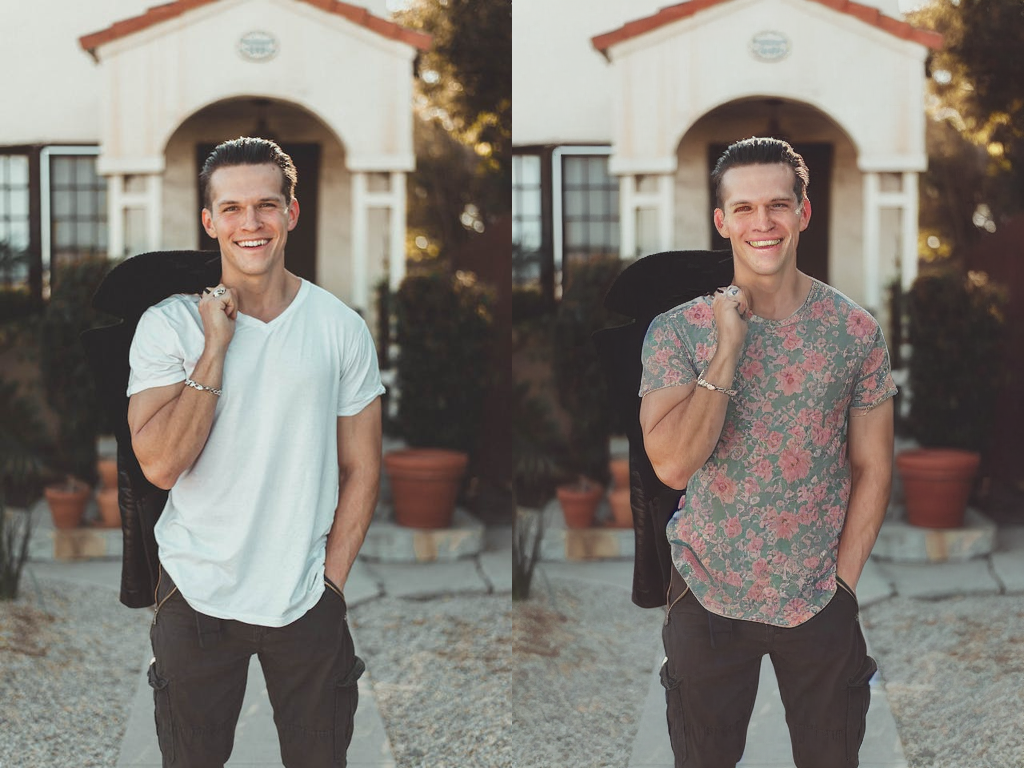

In [ ]:
# compare input and output
make_image_grid([img.resize([512,768]), image1], rows = 1, cols = 2)

## Edit pants in image

  0%|          | 0/30 [00:00<?, ?it/s]

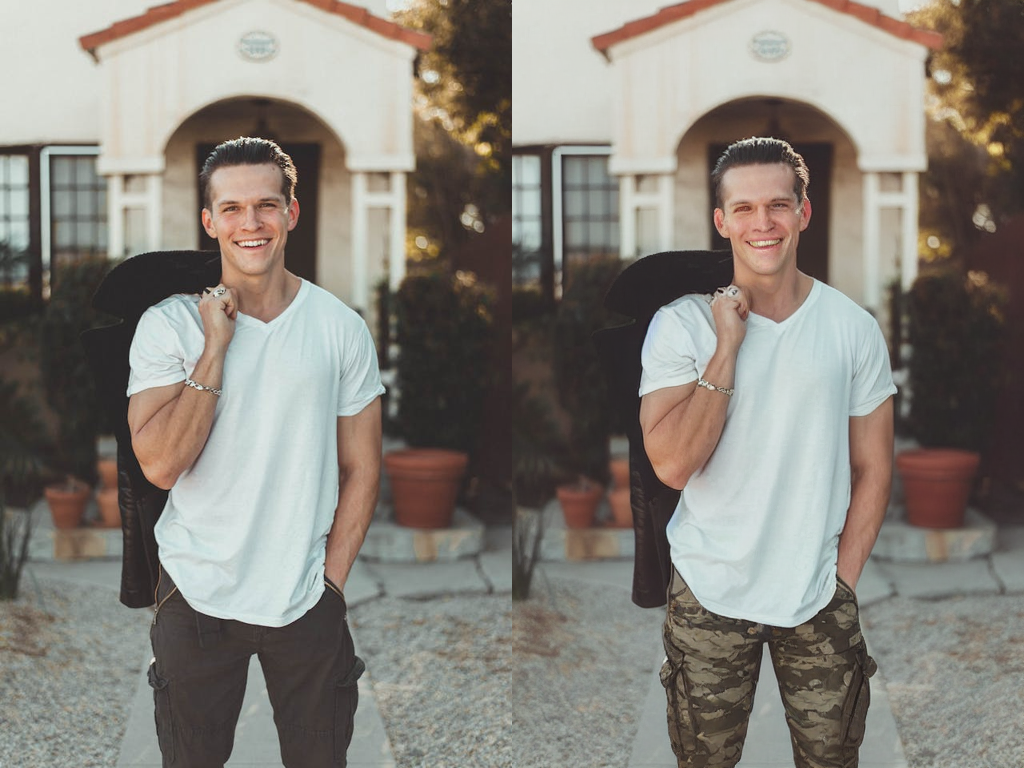

In [ ]:
prompt = "tactical pants"

image = pipeline(prompt=prompt,
                 width=512,
                 height=768,
                 num_inference_steps=30,
                 image=img,
                 mask_image=mask_2,
                 guidance_scale=2.5,
                 strength=1.0).images[0]

make_image_grid([img.resize([512,768]), image], rows = 1, cols = 2)

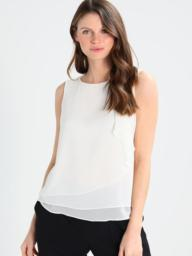

In [ ]:
# load image
img = load_image("/content/019490_0.jpg")

# display image
img

In [ ]:
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-50").to("cuda")
processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-50")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
input_points = [[[100, 150]]] # coordinates of a point on the object of interest

inputs = processor(img, input_points=input_points, return_tensors="pt").to("cuda")
outputs = model(**inputs)

# extract mask tensors
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

In [ ]:
# count number of masks
len(masks[0][0])

3

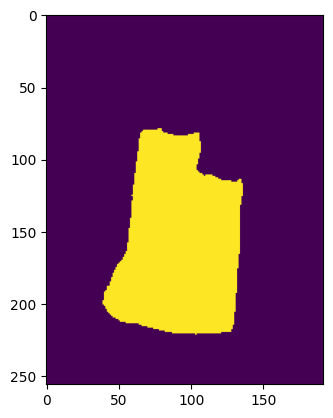

In [ ]:
# best mask tensor
plt.imshow(masks[0][0][2])

In [ ]:
input_points_2 = [[[100, 210]]] # coordinates of a point on the object of interest

inputs_2 = processor(img, input_points=input_points_2, return_tensors="pt").to("cuda")
outputs_2 = model(**inputs_2)
masks_2 = processor.image_processor.post_process_masks(outputs_2.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

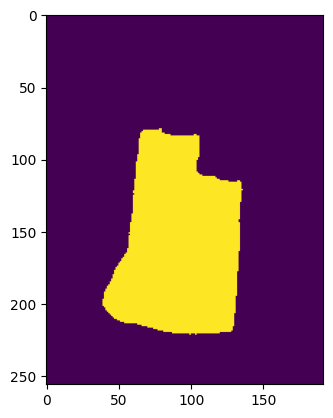

In [ ]:
plt.imshow(masks_2[0][0][1])

In [ ]:
# Create a ToPILImage transform
to_pil = transforms.ToPILImage()

# Convert boolean tensors to binary tensors
binary_matrix_1 = masks[0][0][2].to(dtype=torch.uint8)


# apply the transform to the tensors (tensor to PIL)
mask_1 = to_pil(binary_matrix_1*255)


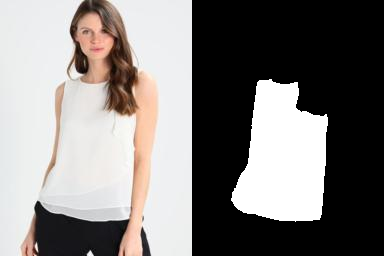

In [ ]:
make_image_grid([img, mask_1], cols = 2, rows = 1)

In [ ]:
# Create inpainting pipeline
pipeline = AutoPipelineForInpainting.from_pretrained(
    "redstonehero/ReV_Animated_Inpainting",
    torch_dtype=torch.float16
)

pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--redstonehero--ReV_Animated_Inpainting/snapshots/0eb626cc745ef55ec63898d7a939b8c770273be8/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/p

In [ ]:
img.size

(192, 256)

In [ ]:
prompt = "flower-print, t-shirt"

# inpainting pipeline
image1 = pipeline(prompt=prompt,
                 width=192,
                 height=256,
                 num_inference_steps=28,
                 image=img,
                 mask_image=mask_1,
                 guidance_scale=3,
                 strength=1.0).images[0]

  0%|          | 0/28 [00:00<?, ?it/s]

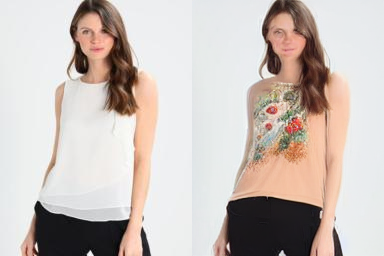

In [ ]:
# compare input and output
make_image_grid([img.resize([192,256]), image1], rows = 1, cols = 2)

We can also use an [IP-Adapter model](https://pjoshi15.com/generate-images-ipadapters-diffusers/) here to use an existing dress and guide the model to generate a similar dress. There is a wide range of things that we can do if we combine different AI models, like how combining SlimSAM and Stable Diffusion helped in generating new clothes in the images.